# Load PHEME dataset

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 55.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 59.1 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import seaborn as sns
from sklearn.metrics import accuracy_score, recall_score, f1_score
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import transformers
import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, Conv2D,MaxPooling1D, MaxPooling2D, Flatten, Dense, Dropout, LSTM, BatchNormalization, Input, Concatenate, GlobalMaxPooling1D
import requests
from tensorflow.keras import activations, optimizers, losses
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

In [ ]:
path = '/content/drive/MyDrive/PHEME/data.csv'
df = pd.read_csv(path,delimiter=',')

In [ ]:
df.head()

,text,target
0,What we know so far about the major operation ...,true
1,"Fact that the Gunmen were shouting ""Allah Hu A...",unverified
2,Gunmen showed advanced military skills in Pari...,unverified
3,BREAKING: Police official confirms that 12 hav...,true
4,#BREAKING : Both hostages in #Dammartin and #P...,true


In [ ]:
label_encoder = LabelEncoder()
label = df['target']
labels_encoded = label_encoder.fit_transform(label)
df['target'] = labels_encoded
df.head()

,text,target
0,What we know so far about the major operation ...,1
1,"Fact that the Gunmen were shouting ""Allah Hu A...",2
2,Gunmen showed advanced military skills in Pari...,2
3,BREAKING: Police official confirms that 12 hav...,1
4,#BREAKING : Both hostages in #Dammartin and #P...,1


# DistilBERT train

In [ ]:
tokenizer_distil = DistilBertTokenizer.from_pretrained('distilbert-base-uncased',padding=True, truncation=True, return_tensors='tf',add_special_tokens=True)
model_distil = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased',num_labels=3,output_hidden_states=True)

for layer in model_distil.layers:
    layer.trainable = True

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'vocab_projector', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'pre_classifier', 'dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use i

In [ ]:
def construct_encodings(x, tkzr, max_len, trucation=True, padding=True):
    return tokenizer_distil(x, max_length=max_len, truncation=trucation, padding=padding)
    
encodings = construct_encodings(df['text'].tolist(), tokenizer_distil, max_len=512)

In [ ]:
def construct_tfdataset(encodings, y=None):
    if y:
        return tf.data.Dataset.from_tensor_slices((dict(encodings),y))
    else:
        # this case is used when making predictions on unseen samples after training
        return tf.data.Dataset.from_tensor_slices(dict(encodings))
    
tfdataset = construct_tfdataset(encodings, df['target'].tolist())

In [ ]:
TEST_SPLIT = 0.2
BATCH_SIZE = 2

train_size = int(len(df['text'].tolist()) * (1-TEST_SPLIT))

tfdataset = tfdataset.shuffle(len(df['text'].tolist()))
tfdataset_train = tfdataset.take(train_size)
tfdataset_test = tfdataset.skip(train_size)

tfdataset_train = tfdataset_train.batch(BATCH_SIZE)
tfdataset_test = tfdataset_test.batch(BATCH_SIZE)

In [ ]:
N_EPOCHS = 2
optimizer = optimizers.Adam(learning_rate=3e-5)
loss = losses.SparseCategoricalCrossentropy(from_logits=True)
model_distil.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
model_distil.fit(tfdataset_train, batch_size=BATCH_SIZE, epochs=N_EPOCHS)

Epoch 1/2
961/961 [==============================] - 80s 56ms/step - loss: 0.6958 - accuracy: 0.7126
Epoch 2/2
961/961 [==============================] - 55s 57ms/step - loss: 0.4658 - accuracy: 0.8267


In [ ]:
benchmarks = model_distil.evaluate(tfdataset_test, return_dict=True, batch_size=BATCH_SIZE)

241/241 [==============================] - 6s 19ms/step - loss: 0.2758 - accuracy: 0.9023


In [ ]:
print(benchmarks)

{'loss': 0.27576181292533875, 'accuracy': 0.9022868871688843}


In [ ]:
model_distil.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
Total params: 66,955,779
Trainable params: 2,307
Non-trainable params: 66,953,472
_________________________________________________________________


# DistilBERT text

In [ ]:
import nltk
def get_embeddings(texts):
    encoded = tokenizer_distil(
      texts,
      add_special_tokens=True,
      padding=True,
      truncation=True,
      max_length=512,
      return_tensors="tf"
    )
    outputs = model_distil(encoded)
    embeddings = outputs.hidden_states[-1]
    avg_embeddings = tf.reduce_mean(embeddings, axis=1)
    return avg_embeddings

In [ ]:
from tqdm import tqdm

#εφαρμόζουme τη συνάρτηση στη στήλη με τους τίτλους
batch_size = 1
titles = df['text'].tolist()
embeddings = []

for i in tqdm(range(0, len(titles), batch_size)):
    batch_titles = titles[i:i+batch_size]
  
    batch_embeddings = get_embeddings(batch_titles)
    
    embeddings.append(batch_embeddings)

100%|██████████| 2402/2402 [04:58<00:00,  8.06it/s]


In [ ]:
embeddings = tf.concat(embeddings,axis=0)

In [ ]:
labels = df['target'].to_numpy()

In [ ]:
np.save('/content/drive/MyDrive/PHEME/embeddings.npy', np.array(embeddings))
np.save('/content/drive/MyDrive/PHEME/labels.npy', labels)

# **CNN-DistilBERT-Titles**

In [ ]:
#εισάγουμε τα δεδομένα από τ' αποθηκευμένα αρχεία που δημιουργήσαμε νωρίτερα
embeddings = np.load('/content/drive/MyDrive/PHEME/embeddings.npy')
labels = np.load('/content/drive/MyDrive/PHEME/labels.npy')

In [ ]:
train_embeddings, test_embeddings, train_labels, test_labels = train_test_split(embeddings, labels, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
train_embeddings = tf.expand_dims(train_embeddings, axis=-1)
test_embeddings = tf.expand_dims(test_embeddings, axis=-1)

In [ ]:
train_embeddings.shape

TensorShape([1921, 768, 1])

In [ ]:
train_labels = to_categorical(train_labels, num_classes=3)
test_labels = to_categorical(test_labels, num_classes=3)

In [ ]:
# build the model
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(768,1)))
model.add(MaxPooling1D(pool_size=5))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=5))
model.add(Conv1D(128, 5, activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))


In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history1 = model.fit(train_embeddings, train_labels, epochs=10, batch_size=8,validation_data=(test_embeddings, test_labels))

Epoch 1/10
241/241 [==============================] - 4s 7ms/step - loss: 0.3398 - accuracy: 0.7923 - val_loss: 0.2135 - val_accuracy: 0.8981
Epoch 2/10
241/241 [==============================] - 1s 6ms/step - loss: 0.2284 - accuracy: 0.8954 - val_loss: 0.1792 - val_accuracy: 0.9002
Epoch 3/10
241/241 [==============================] - 1s 6ms/step - loss: 0.2032 - accuracy: 0.9037 - val_loss: 0.1786 - val_accuracy: 0.9044
Epoch 4/10
241/241 [==============================] - 2s 7ms/step - loss: 0.1937 - accuracy: 0.9063 - val_loss: 0.1803 - val_accuracy: 0.9085
Epoch 5/10
241/241 [==============================] - 2s 8ms/step - loss: 0.1837 - accuracy: 0.9141 - val_loss: 0.1747 - val_accuracy: 0.9064
Epoch 6/10
241/241 [==============================] - 2s 9ms/step - loss: 0.1688 - accuracy: 0.9120 - val_loss: 0.1678 - val_accuracy: 0.9085
Epoch 7/10
241/241 [==============================] - 1s 6ms/step - loss: 0.1596 - accuracy: 0.9240 - val_loss: 0.1624 - val_accuracy: 0.9085
Epoch 

In [ ]:
a = np.asarray(test_labels).argmax(axis=1)

In [ ]:
test_loss, test_acc = model.evaluate(test_embeddings, test_labels)

y_pred = model.predict(test_embeddings)
y_pred = y_pred.argmax(axis=1)



f1 = f1_score(a,y_pred,average='macro')
recall = recall_score(a, y_pred,average='macro')
precision = precision_score(a, y_pred,average='macro')

#accuraccy 
print("Test Accuracy:", test_acc)
#f1-score
print("Test F1 Score:", f1)
#recall
print("Test Recall:", recall)
#precision
print("Precision:", precision)

16/16 [==============================] - 0s 3ms/step
Test Accuracy: 0.9085239171981812
Test F1 Score: 0.9042304453944969
Test Recall: 0.902079654531982
Precision: 0.9065905496604042


In [ ]:
#λεπτομέρειες για τη δομή του μοντέλου
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 764, 128)          768       
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 152, 128)         0         
 1D)                                                             
                                                                 
 conv1d_10 (Conv1D)          (None, 148, 128)          82048     
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 29, 128)          0         
 1D)                                                             
                                                                 
 conv1d_11 (Conv1D)          (None, 25, 128)           82048     
                                                                 
 flatten_3 (Flatten)         (None, 3200)             

In [ ]:
y_pred = model.predict(test_embeddings)
y_pred = y_pred.argmax(axis=1)
cm = confusion_matrix(a, y_pred)
print(cm)

16/16 [==============================] - 0s 3ms/step
[[105   4   9]
 [  4 202   8]
 [  6  13 130]]


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
def plot_history(history,model):
   # Plot training and validation loss
    sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
    sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='val')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()
    
    # Plot training and validation accuracy
    sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
    sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='val')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.show()
    
    # Print the classification report
    print(classification_report(a, y_pred))

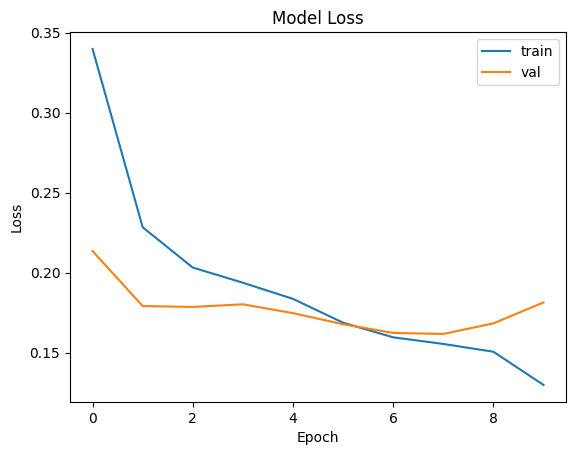

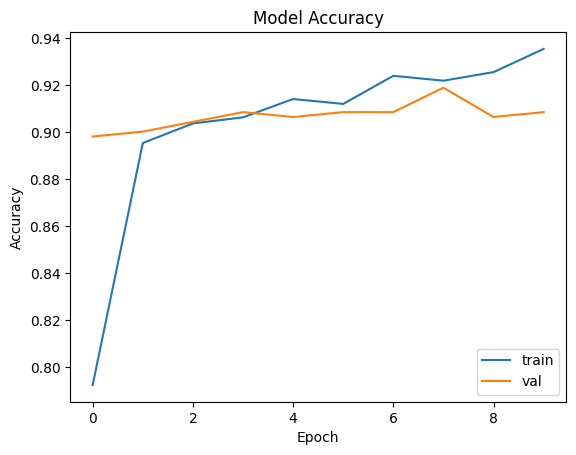

              precision    recall  f1-score   support

           0       0.91      0.89      0.90       118
           1       0.92      0.94      0.93       214
           2       0.88      0.87      0.88       149

    accuracy                           0.91       481
   macro avg       0.91      0.90      0.90       481
weighted avg       0.91      0.91      0.91       481



In [ ]:
plot_history(history1,model)

# **LSTM-DistilBERT-Titles**

In [ ]:
model2 = Sequential()
model2.add(Conv1D(64, 5, activation='relu', input_shape=(768, 1)))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Conv1D(64, 5, activation='relu'))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Conv1D(64, 5, activation='relu'))
model2.add(LSTM(64, return_sequences=True))
model2.add(Dropout(0.2))
model2.add(BatchNormalization())
model2.add(Dense(64, activation='relu', kernel_regularizer='l2'))
model2.add(Dropout(0.2))
model2.add(Flatten())
model2.add(Dense(3, activation='softmax'))

In [ ]:
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history2 = model2.fit(train_embeddings, train_labels, epochs=10, batch_size=16, validation_data=(test_embeddings, test_labels))

Epoch 1/10
121/121 [==============================] - 11s 21ms/step - loss: 0.6053 - accuracy: 0.8798 - val_loss: 0.7646 - val_accuracy: 0.9023
Epoch 2/10
121/121 [==============================] - 4s 32ms/step - loss: 0.2997 - accuracy: 0.9032 - val_loss: 0.5376 - val_accuracy: 0.8669
Epoch 3/10
121/121 [==============================] - 3s 25ms/step - loss: 0.2083 - accuracy: 0.9157 - val_loss: 0.3674 - val_accuracy: 0.8732
Epoch 4/10
121/121 [==============================] - 2s 19ms/step - loss: 0.1792 - accuracy: 0.9198 - val_loss: 0.2087 - val_accuracy: 0.9064
Epoch 5/10
121/121 [==============================] - 2s 21ms/step - loss: 0.1604 - accuracy: 0.9193 - val_loss: 0.2067 - val_accuracy: 0.9023
Epoch 6/10
121/121 [==============================] - 3s 27ms/step - loss: 0.1556 - accuracy: 0.9235 - val_loss: 0.1868 - val_accuracy: 0.9168
Epoch 7/10
121/121 [==============================] - 5s 41ms/step - loss: 0.1448 - accuracy: 0.9308 - val_loss: 0.1819 - val_accuracy: 0.904

In [ ]:
test_loss, test_acc = model2.evaluate(test_embeddings, test_labels)

y_pred = model2.predict(test_embeddings)
y_pred = y_pred.argmax(axis=1)



f1 = f1_score(a,y_pred,average='macro')
recall = recall_score(a, y_pred,average='macro')
precision = precision_score(a, y_pred,average='macro')

#accuraccy 
print("Test Accuracy:", test_acc)
#f1-score
print("Test F1 Score:", f1)
#recall
print("Test Recall:", recall)
#precision
print("Precision:", precision)

16/16 [==============================] - 1s 13ms/step
Test Accuracy: 0.9189189076423645
Test F1 Score: 0.9167388093176877
Test Recall: 0.9144407814420795
Precision: 0.9192731484932186


In [ ]:
#λεπτομέρειες για τη δομή του μοντέλου
model2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_18 (Conv1D)          (None, 764, 64)           384       
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 382, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_19 (Conv1D)          (None, 378, 64)           20544     
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 189, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_20 (Conv1D)          (None, 185, 64)           20544     
                                                                 
 lstm_2 (LSTM)               (None, 185, 64)          

In [ ]:
y_pred = model2.predict(test_embeddings)
y_pred = y_pred.argmax(axis=1)
cm = confusion_matrix(a, y_pred)
print(cm)

16/16 [==============================] - 0s 9ms/step
[[107   5   6]
 [  2 202  10]
 [  5  11 133]]


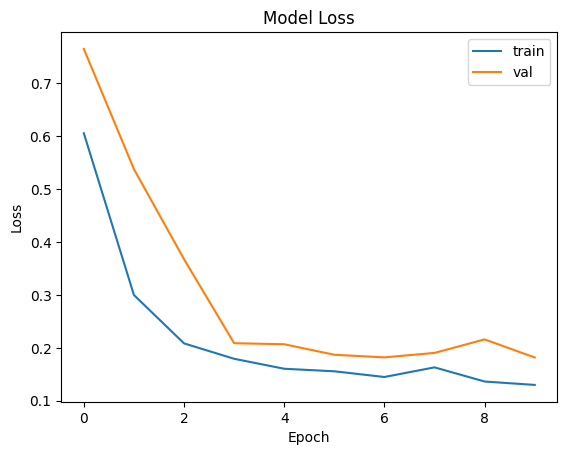

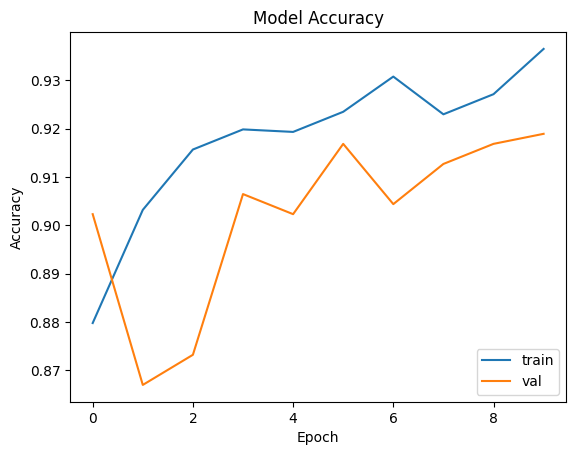

              precision    recall  f1-score   support

           0       0.94      0.91      0.92       118
           1       0.93      0.94      0.94       214
           2       0.89      0.89      0.89       149

    accuracy                           0.92       481
   macro avg       0.92      0.91      0.92       481
weighted avg       0.92      0.92      0.92       481



In [ ]:
plot_history(history2,model2)

# **FakeBert-DistilBERT-Titles**

In [ ]:
inputs = Input(shape=(768, 1))
conv1 = Conv1D(128, 3, activation='relu', padding='same')(inputs)
maxpool1 = MaxPooling1D(pool_size=2)(conv1)
conv2 = Conv1D(128, 4, activation='relu', padding='same')(inputs)
maxpool2 = MaxPooling1D(pool_size=2)(conv2)
conv3 = Conv1D(128, 5, activation='relu', padding='same')(inputs)
maxpool3 = MaxPooling1D(pool_size=2)(conv3)
concat = Concatenate()([maxpool1, maxpool2, maxpool3])
conv4 = Conv1D(128, 5, activation='relu', padding='same')(concat)
maxpool4 = MaxPooling1D(pool_size=2)(conv4)
flatten = Flatten()(maxpool4)
dense1 = Dense(384, activation='relu')(flatten)
dropout1 = Dropout(0.5)(dense1)
dense2 = Dense(128, activation='relu')(dropout1)
dropout2 = Dropout(0.5)(dense2)
output = Dense(3, activation='softmax')(dropout2)

model3 = Model(inputs=inputs, outputs=output)

In [ ]:
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history3 = model3.fit(train_embeddings, train_labels, epochs=10, batch_size=16, validation_data=(test_embeddings, test_labels))

Epoch 1/10
121/121 [==============================] - 6s 14ms/step - loss: 0.2756 - accuracy: 0.8563 - val_loss: 0.1816 - val_accuracy: 0.8919
Epoch 2/10
121/121 [==============================] - 1s 11ms/step - loss: 0.2063 - accuracy: 0.9079 - val_loss: 0.1759 - val_accuracy: 0.9085
Epoch 3/10
121/121 [==============================] - 1s 11ms/step - loss: 0.1861 - accuracy: 0.9099 - val_loss: 0.1678 - val_accuracy: 0.9148
Epoch 4/10
121/121 [==============================] - 1s 12ms/step - loss: 0.1699 - accuracy: 0.9219 - val_loss: 0.1578 - val_accuracy: 0.9064
Epoch 5/10
121/121 [==============================] - 1s 11ms/step - loss: 0.1473 - accuracy: 0.9282 - val_loss: 0.1521 - val_accuracy: 0.9106
Epoch 6/10
121/121 [==============================] - 2s 14ms/step - loss: 0.1388 - accuracy: 0.9344 - val_loss: 0.1459 - val_accuracy: 0.9106
Epoch 7/10
121/121 [==============================] - 2s 18ms/step - loss: 0.1199 - accuracy: 0.9438 - val_loss: 0.1473 - val_accuracy: 0.9168

In [ ]:
test_loss, test_acc = model3.evaluate(test_embeddings, test_labels)

y_pred = model3.predict(test_embeddings)
y_pred = y_pred.argmax(axis=1)



f1 = f1_score(a,y_pred,average='macro')
recall = recall_score(a, y_pred,average='macro')
precision = precision_score(a, y_pred,average='macro')

#accuraccy 
print("Test Accuracy:", test_acc)
#f1-score
print("Test F1 Score:", f1)
#recall
print("Test Recall:", recall)
#precision
print("Precision:", precision)

16/16 [==============================] - 0s 6ms/step
Test Accuracy: 0.9106029272079468
Test F1 Score: 0.9092816699226051
Test Recall: 0.9119201491471559
Precision: 0.9069691642862375


In [ ]:
y_pred = model3.predict(test_embeddings)
y_pred = y_pred.argmax(axis=1)
cm = confusion_matrix(a, y_pred)
print(cm)

16/16 [==============================] - 0s 9ms/step
[[111   3   4]
 [  5 196  13]
 [  7  11 131]]


# **PHEME Binary**

In [ ]:
path = '/content/drive/MyDrive/PHEME/data.csv'
df = pd.read_csv(path,delimiter=',')

In [ ]:
df = df[df['target'] != 'unverified']

In [ ]:
df.head()

,text,target
0,What we know so far about the major operation ...,true
3,BREAKING: Police official confirms that 12 hav...,true
4,#BREAKING : Both hostages in #Dammartin and #P...,true
5,Update - French interior ministry says inciden...,false
7,This widely shared cartoon about the #CharlieH...,false


In [ ]:
label_encoder = LabelEncoder()
label = df['target']
labels_encoded = label_encoder.fit_transform(label)
df['target'] = labels_encoded
df.head()

,text,target
0,What we know so far about the major operation ...,1
3,BREAKING: Police official confirms that 12 hav...,1
4,#BREAKING : Both hostages in #Dammartin and #P...,1
5,Update - French interior ministry says inciden...,0
7,This widely shared cartoon about the #CharlieH...,0


## DistilBERT train

In [ ]:
tokenizer_distil = DistilBertTokenizer.from_pretrained('distilbert-base-uncased',padding=True, truncation=True, return_tensors='tf',add_special_tokens=True)
model_distil = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased',num_labels=2,output_hidden_states=True)

for layer in model_distil.layers:
    layer.trainable = True

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'vocab_projector', 'vocab_layer_norm', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'pre_classifier', 'dropout_19']
You should probably TRAIN this model on a down-stream task to be able to use i

In [ ]:
def construct_encodings(x, tkzr, max_len, trucation=True, padding=True):
    return tokenizer_distil(x, max_length=max_len, truncation=trucation, padding=padding)
    
encodings = construct_encodings(df['text'].tolist(), tokenizer_distil, max_len=512)

In [ ]:
def construct_tfdataset(encodings, y=None):
    if y:
        return tf.data.Dataset.from_tensor_slices((dict(encodings),y))
    else:
        # this case is used when making predictions on unseen samples after training
        return tf.data.Dataset.from_tensor_slices(dict(encodings))
    
tfdataset = construct_tfdataset(encodings, df['target'].tolist())

In [ ]:
TEST_SPLIT = 0.2
BATCH_SIZE = 2

train_size = int(len(df['text'].tolist()) * (1-TEST_SPLIT))

tfdataset = tfdataset.shuffle(len(df['text'].tolist()))
tfdataset_train = tfdataset.take(train_size)
tfdataset_test = tfdataset.skip(train_size)

tfdataset_train = tfdataset_train.batch(BATCH_SIZE)
tfdataset_test = tfdataset_test.batch(BATCH_SIZE)

In [ ]:
N_EPOCHS = 2
optimizer = optimizers.Adam(learning_rate=3e-5)
loss = losses.SparseCategoricalCrossentropy(from_logits=True)
model_distil.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
model_distil.fit(tfdataset_train, batch_size=BATCH_SIZE, epochs=N_EPOCHS)

Epoch 1/2
682/682 [==============================] - 92s 79ms/step - loss: 0.4576 - accuracy: 0.7742
Epoch 2/2
682/682 [==============================] - 32s 46ms/step - loss: 0.2962 - accuracy: 0.8666


In [ ]:
benchmarks = model_distil.evaluate(tfdataset_test, return_dict=True, batch_size=BATCH_SIZE)

171/171 [==============================] - 4s 15ms/step - loss: 0.1536 - accuracy: 0.9326


In [ ]:
print(benchmarks)

{'loss': 0.1536487191915512, 'accuracy': 0.9325513243675232}


In [ ]:
model_distil.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
Total params: 66,955,779
Trainable params: 2,307
Non-trainable params: 66,953,472
_________________________________________________________________


# DistilBERT text

In [ ]:
import nltk
def get_embeddings(texts):
    encoded = tokenizer_distil(
      texts,
      add_special_tokens=True,
      padding=True,
      truncation=True,
      max_length=512,
      return_tensors="tf"
    )
    outputs = model_distil(encoded)
    embeddings = outputs.hidden_states[-1]
    avg_embeddings = tf.reduce_mean(embeddings, axis=1)
    return avg_embeddings

In [ ]:
from tqdm import tqdm

#εφαρμόζουme τη συνάρτηση στη στήλη με τους τίτλους
batch_size = 1
titles = df['text'].tolist()
embeddings = []

for i in tqdm(range(0, len(titles), batch_size)):
    batch_titles = titles[i:i+batch_size]
  
    batch_embeddings = get_embeddings(batch_titles)
    
    embeddings.append(batch_embeddings)

100%|██████████| 1705/1705 [03:02<00:00,  9.33it/s]


In [ ]:
embeddings = tf.concat(embeddings,axis=0)

In [ ]:
labels = df['target'].to_numpy()

In [ ]:
np.save('/content/drive/MyDrive/PHEME/embeddings_bin.npy', np.array(embeddings))
np.save('/content/drive/MyDrive/PHEME/labels_bin.npy', labels)

# **CNN-DistilBERT-Titles**

In [ ]:
#εισάγουμε τα δεδομένα από τ' αποθηκευμένα αρχεία που δημιουργήσαμε νωρίτερα
embeddings = np.load('/content/drive/MyDrive/PHEME/embeddings_bin.npy')
labels = np.load('/content/drive/MyDrive/PHEME/labels_bin.npy')

In [ ]:
train_embeddings, test_embeddings, train_labels, test_labels = train_test_split(embeddings, labels, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
train_embeddings = tf.expand_dims(train_embeddings, axis=-1)
test_embeddings = tf.expand_dims(test_embeddings, axis=-1)

In [ ]:
train_embeddings.shape

TensorShape([1364, 768, 1])

In [ ]:
# build the model
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(768,1)))
model.add(MaxPooling1D(pool_size=5))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=5))
model.add(Conv1D(128, 5, activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))


In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history1 = model.fit(train_embeddings, train_labels, epochs=10, batch_size=8,validation_data=(test_embeddings, test_labels))

Epoch 1/10
171/171 [==============================] - 3s 7ms/step - loss: 0.2427 - accuracy: 0.8974 - val_loss: 0.1134 - val_accuracy: 0.9501
Epoch 2/10
171/171 [==============================] - 1s 5ms/step - loss: 0.1792 - accuracy: 0.9428 - val_loss: 0.1086 - val_accuracy: 0.9589
Epoch 3/10
171/171 [==============================] - 1s 5ms/step - loss: 0.1550 - accuracy: 0.9450 - val_loss: 0.1081 - val_accuracy: 0.9531
Epoch 4/10
171/171 [==============================] - 1s 5ms/step - loss: 0.1410 - accuracy: 0.9465 - val_loss: 0.1120 - val_accuracy: 0.9677
Epoch 5/10
171/171 [==============================] - 1s 6ms/step - loss: 0.1425 - accuracy: 0.9494 - val_loss: 0.1031 - val_accuracy: 0.9619
Epoch 6/10
171/171 [==============================] - 1s 7ms/step - loss: 0.1298 - accuracy: 0.9479 - val_loss: 0.1048 - val_accuracy: 0.9619
Epoch 7/10
171/171 [==============================] - 2s 9ms/step - loss: 0.1177 - accuracy: 0.9560 - val_loss: 0.1071 - val_accuracy: 0.9648
Epoch 

In [ ]:
test_loss, test_acc = model.evaluate(test_embeddings, test_labels)

y_pred = model.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype('int32')

f1 = f1_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)

#accuraccy 
print("Test Accuracy:", test_acc)
#f1-score
print("Test F1 Score:", f1)
#recall
print("Test Recall:", recall)
#precision
print("Precision:", precision)

11/11 [==============================] - 0s 6ms/step
Test Accuracy: 0.9530791640281677
Test F1 Score: 0.9634703196347032
Test Recall: 0.9504504504504504
Precision: 0.9768518518518519


In [ ]:
#λεπτομέρειες για τη δομή του μοντέλου
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 764, 128)          768       
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 152, 128)         0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 148, 128)          82048     
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 29, 128)          0         
 1D)                                                             
                                                                 
 conv1d_8 (Conv1D)           (None, 25, 128)           82048     
                                                                 
 flatten_2 (Flatten)         (None, 3200)             

In [ ]:
y_pred = model.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(test_labels, y_pred)
print(cm)

11/11 [==============================] - 0s 2ms/step
[[114   5]
 [ 11 211]]


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
def plot_history(history,model):
   # Plot training and validation loss
    sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
    sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='val')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()
    
    # Plot training and validation accuracy
    sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
    sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='val')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.show()

    y_pred = model.predict(test_embeddings)
    y_pred = (y_pred > 0.5).astype(int)
    cm = confusion_matrix(test_labels, y_pred)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion matrix')
    plt.show()
    
    # Print the classification report
    print(classification_report(test_labels, y_pred))

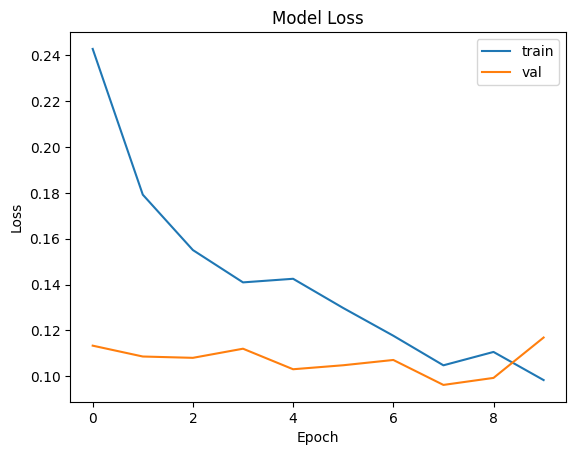

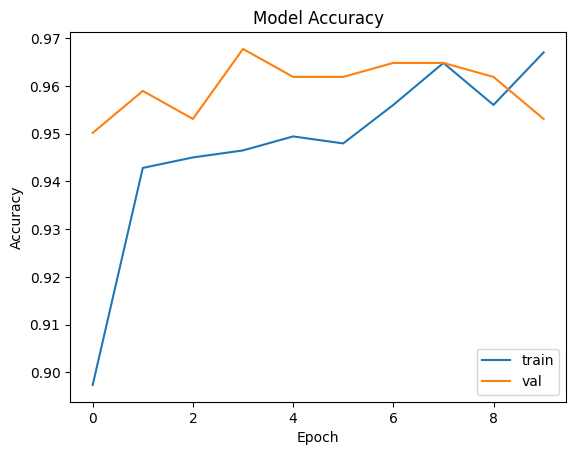

11/11 [==============================] - 0s 3ms/step


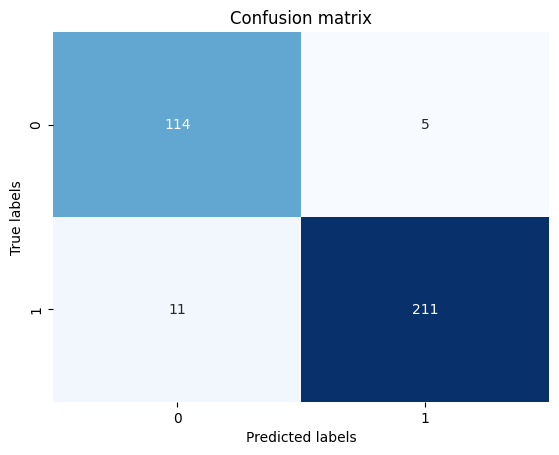

              precision    recall  f1-score   support

           0       0.91      0.96      0.93       119
           1       0.98      0.95      0.96       222

    accuracy                           0.95       341
   macro avg       0.94      0.95      0.95       341
weighted avg       0.95      0.95      0.95       341



In [ ]:
plot_history(history1,model)

# **LSTM-DistilBERT-Titles**

In [ ]:
model2 = Sequential()
model2.add(Conv1D(64, 5, activation='relu', input_shape=(768, 1)))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Conv1D(64, 5, activation='relu'))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Conv1D(64, 5, activation='relu'))
model2.add(LSTM(64, return_sequences=True))
model2.add(Dropout(0.2))
model2.add(BatchNormalization())
model2.add(Dense(64, activation='relu', kernel_regularizer='l2'))
model2.add(Dropout(0.2))
model2.add(Flatten())
model2.add(Dense(1, activation='sigmoid'))

In [ ]:
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history2 = model2.fit(train_embeddings, train_labels, epochs=10, batch_size=16, validation_data=(test_embeddings, test_labels))

Epoch 1/10
86/86 [==============================] - 8s 23ms/step - loss: 0.6880 - accuracy: 0.9179 - val_loss: 0.8952 - val_accuracy: 0.9560
Epoch 2/10
86/86 [==============================] - 1s 12ms/step - loss: 0.4221 - accuracy: 0.9435 - val_loss: 0.7541 - val_accuracy: 0.9589
Epoch 3/10
86/86 [==============================] - 1s 12ms/step - loss: 0.3015 - accuracy: 0.9516 - val_loss: 0.4827 - val_accuracy: 0.9619
Epoch 4/10
86/86 [==============================] - 1s 11ms/step - loss: 0.2308 - accuracy: 0.9413 - val_loss: 0.4076 - val_accuracy: 0.9472
Epoch 5/10
86/86 [==============================] - 1s 13ms/step - loss: 0.1864 - accuracy: 0.9501 - val_loss: 0.2523 - val_accuracy: 0.9589
Epoch 6/10
86/86 [==============================] - 1s 17ms/step - loss: 0.1565 - accuracy: 0.9531 - val_loss: 0.1274 - val_accuracy: 0.9648
Epoch 7/10
86/86 [==============================] - 2s 19ms/step - loss: 0.1409 - accuracy: 0.9589 - val_loss: 0.1191 - val_accuracy: 0.9707
Epoch 8/10
86

In [ ]:
test_loss, test_acc = model2.evaluate(test_embeddings, test_labels, verbose=2)

y_pred = model2.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype('int32')

f1 = f1_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)

print("Test Accuracy:", test_acc)
print("Test F1 Score:", f1)
print("Test Recall:", recall)
print("Precision:", precision)

11/11 - 0s - loss: 0.1144 - accuracy: 0.9560 - 219ms/epoch - 20ms/step
11/11 [==============================] - 1s 6ms/step
Test Accuracy: 0.9560117125511169
Test F1 Score: 0.9668874172185431
Test Recall: 0.9864864864864865
Precision: 0.948051948051948


In [ ]:
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 764, 64)           384       
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 382, 64)          0         
 1D)                                                             
                                                                 
 conv1d_10 (Conv1D)          (None, 378, 64)           20544     
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 189, 64)          0         
 1D)                                                             
                                                                 
 conv1d_11 (Conv1D)          (None, 185, 64)           20544     
                                                                 
 lstm (LSTM)                 (None, 185, 64)          

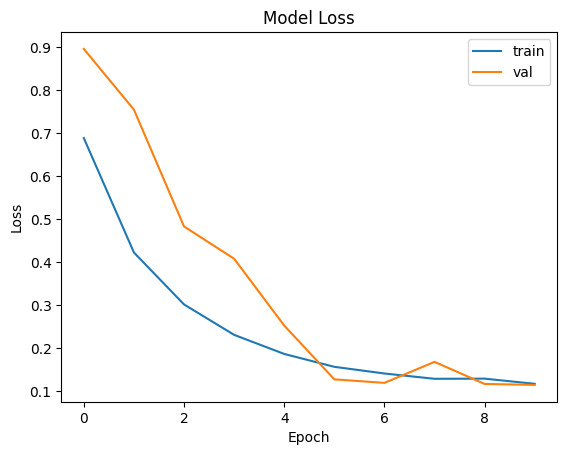

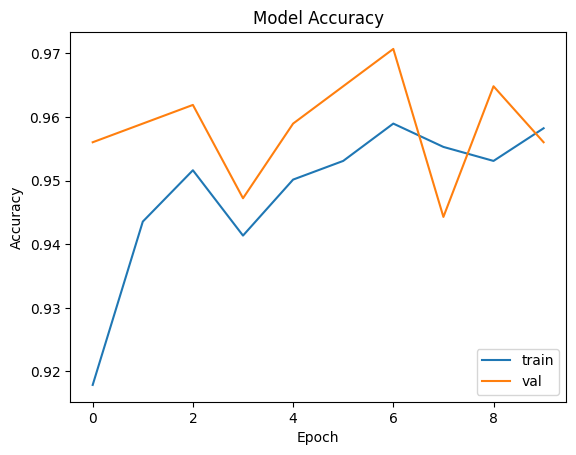

11/11 [==============================] - 0s 9ms/step


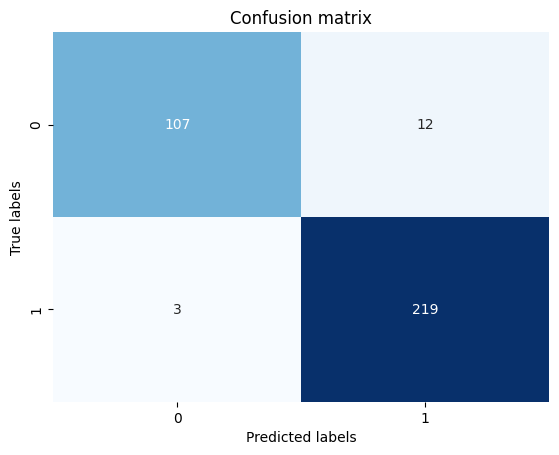

              precision    recall  f1-score   support

           0       0.97      0.90      0.93       119
           1       0.95      0.99      0.97       222

    accuracy                           0.96       341
   macro avg       0.96      0.94      0.95       341
weighted avg       0.96      0.96      0.96       341



In [ ]:
plot_history(history2,model2)

# **FakeBert-DistilBERT-Titles**

In [ ]:
inputs = Input(shape=(768, 1))
conv1 = Conv1D(128, 3, activation='relu', padding='same')(inputs)
maxpool1 = MaxPooling1D(pool_size=2)(conv1)
conv2 = Conv1D(128, 4, activation='relu', padding='same')(inputs)
maxpool2 = MaxPooling1D(pool_size=2)(conv2)
conv3 = Conv1D(128, 5, activation='relu', padding='same')(inputs)
maxpool3 = MaxPooling1D(pool_size=2)(conv3)
concat = Concatenate()([maxpool1, maxpool2, maxpool3])
conv4 = Conv1D(128, 5, activation='relu', padding='same')(concat)
maxpool4 = MaxPooling1D(pool_size=2)(conv4)
flatten = Flatten()(maxpool4)
dense1 = Dense(384, activation='relu')(flatten)
dropout1 = Dropout(0.5)(dense1)
dense2 = Dense(128, activation='relu')(dropout1)
dropout2 = Dropout(0.5)(dense2)
output = Dense(1, activation='sigmoid')(dropout2)

model3 = Model(inputs=inputs, outputs=output)

In [ ]:
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history3 = model3.fit(train_embeddings, train_labels, epochs=10, batch_size=16, validation_data=(test_embeddings, test_labels))

Epoch 1/10
86/86 [==============================] - 5s 21ms/step - loss: 0.2416 - accuracy: 0.9040 - val_loss: 0.1019 - val_accuracy: 0.9648
Epoch 2/10
86/86 [==============================] - 1s 13ms/step - loss: 0.1672 - accuracy: 0.9457 - val_loss: 0.0969 - val_accuracy: 0.9648
Epoch 3/10
86/86 [==============================] - 1s 13ms/step - loss: 0.1488 - accuracy: 0.9465 - val_loss: 0.0936 - val_accuracy: 0.9677
Epoch 4/10
86/86 [==============================] - 1s 12ms/step - loss: 0.1495 - accuracy: 0.9450 - val_loss: 0.1047 - val_accuracy: 0.9560
Epoch 5/10
86/86 [==============================] - 1s 12ms/step - loss: 0.1359 - accuracy: 0.9531 - val_loss: 0.0935 - val_accuracy: 0.9707
Epoch 6/10
86/86 [==============================] - 1s 12ms/step - loss: 0.1240 - accuracy: 0.9523 - val_loss: 0.0883 - val_accuracy: 0.9677
Epoch 7/10
86/86 [==============================] - 1s 12ms/step - loss: 0.1153 - accuracy: 0.9567 - val_loss: 0.1159 - val_accuracy: 0.9707
Epoch 8/10
86

In [ ]:
test_loss, test_acc = model3.evaluate(test_embeddings, test_labels, verbose=2)

y_pred = model3.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype('int32')

f1 = f1_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)

print("Test Accuracy:", test_acc)
print("Test F1 Score:", f1)
print("Test Recall:", recall)
print("Precision:", precision)

11/11 - 0s - loss: 0.0877 - accuracy: 0.9707 - 239ms/epoch - 22ms/step
11/11 [==============================] - 0s 5ms/step
Test Accuracy: 0.9706745147705078
Test F1 Score: 0.9776785714285714
Test Recall: 0.9864864864864865
Precision: 0.9690265486725663


In [ ]:
model3.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 768, 1)]     0           []                               
                                                                                                  
 conv1d_16 (Conv1D)             (None, 768, 128)     512         ['input_2[0][0]']                
                                                                                                  
 conv1d_17 (Conv1D)             (None, 768, 128)     640         ['input_2[0][0]']                
                                                                                                  
 conv1d_18 (Conv1D)             (None, 768, 128)     768         ['input_2[0][0]']                
                                                                                            

In [ ]:
y_pred = model3.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(test_labels, y_pred)
print(cm)

11/11 [==============================] - 0s 5ms/step
[[112   7]
 [  3 219]]
